# Notebook 7: Multi-Year Training (2018-2024)

## Ultimate Test: 7 Years of Real Weather Data

**Dataset:**
- Source: NSRDB (NREL)
- Location: Phoenix, AZ
- Period: 2018-2024 (7 years)
- Resolution: 10-minute intervals
- Records: ~2.5 million

**Data Split:**
- Training: 2018-2022 (5 years, ~1,825 days)
- Validation: 2023 (1 year, ~365 days)
- Test: 2024 (1 year, completely held-out)

**Goal:** Determine if more diverse weather data reveals patterns RL can exploit.

In [1]:
# Block TensorFlow
import sys
sys.modules['tensorflow'] = None
sys.modules['tensorboard'] = None

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, Any, List
import warnings
warnings.filterwarnings('ignore')
import time
import glob

import pvlib
from pvlib import solarposition, irradiance, tracking, location, shading, atmosphere

import gymnasium as gym
from gymnasium import spaces
import torch
from stable_baselines3 import SAC
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.env_checker import check_env

DEVICE = 'mps' if torch.backends.mps.is_available() else 'cpu'
print(f"✅ Imports successful! Device: {DEVICE.upper()}")

✅ Imports successful! Device: MPS


In [2]:
@dataclass
class SiteConfig:
    name: str = "Phoenix Solar Farm"
    latitude: float = 33.45
    longitude: float = -111.95
    altitude: float = 331
    timezone: str = "US/Arizona"
    gcr: float = 0.35
    axis_azimuth: float = 180
    max_angle: float = 60
    axis_height: float = 1.5
    collector_width: float = 2.2
    terrain_slope: float = 0
    slope_azimuth: float = 180
    capacity_kw: float = 1000
    module_efficiency: float = 0.20
    system_losses: float = 0.14
    temp_coefficient: float = -0.004
    
    @property
    def row_pitch(self) -> float:
        return self.collector_width / self.gcr
    
    @property
    def array_area(self) -> float:
        return self.capacity_kw * 1000 / (1000 * self.module_efficiency)

SITE = SiteConfig()
print(f"Site: {SITE.name}")

Site: Phoenix Solar Farm


## 1. Load Multi-Year NSRDB Data

Upload your downloaded files. The notebook handles:
- Single combined CSV file, OR
- Multiple per-year CSV files

In [3]:
def load_nsrdb_file(filepath: str) -> pd.DataFrame:
    """
    Load a single NSRDB CSV file.
    Handles the 2-row header format.
    """
    print(f"Loading {filepath}...")
    
    # Read with skiprows=2 to skip metadata headers
    df = pd.read_csv(filepath, skiprows=2)
    
    # Create datetime index
    df['datetime'] = pd.to_datetime(
        df[['Year', 'Month', 'Day', 'Hour', 'Minute']].astype(str).agg('-'.join, axis=1),
        format='%Y-%m-%d-%H-%M'
    )
    df = df.set_index('datetime')
    
    # Rename columns
    df = df.rename(columns={
        'Temperature': 'temp_air',
        'Wind Speed': 'wind_speed',
        'GHI': 'ghi',
        'DNI': 'dni',
        'DHI': 'dhi',
    })
    
    # Lowercase column names
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    
    # Select key columns
    key_cols = ['ghi', 'dni', 'dhi', 'temp_air', 'wind_speed']
    df = df[[c for c in key_cols if c in df.columns]]
    
    print(f"   Loaded {len(df):,} records ({df.index.min().year}-{df.index.max().year})")
    
    return df


def load_multi_year_data(file_paths: List[str]) -> pd.DataFrame:
    """
    Load multiple NSRDB files and combine them.
    """
    all_data = []
    
    for filepath in file_paths:
        df = load_nsrdb_file(filepath)
        all_data.append(df)
    
    # Combine all years
    combined = pd.concat(all_data, axis=0)
    combined = combined.sort_index()
    
    # Remove duplicates if any
    combined = combined[~combined.index.duplicated(keep='first')]
    
    # Localize timezone
    if combined.index.tz is None:
        combined.index = combined.index.tz_localize('US/Arizona')
    
    print(f"\n✅ Total: {len(combined):,} records")
    print(f"Date range: {combined.index.min()} to {combined.index.max()}")
    print(f"Years: {combined.index.year.unique().tolist()}")
    
    return combined

In [15]:
# Load all CSV files from uploads folder
import glob

file_paths = sorted(glob.glob('uploads/*.csv'))
print(f"Found {len(file_paths)} CSV files:")
for f in file_paths:
    print(f"   {f}")

# Load and combine all files
nsrdb_data = load_multi_year_data(file_paths)

print(f"\nData shape: {nsrdb_data.shape}")
print(f"Memory usage: {nsrdb_data.memory_usage().sum() / 1e6:.1f} MB")
print(f"Years: {sorted(nsrdb_data.index.year.unique())}")
nsrdb_data.head()

Found 7 CSV files:
   uploads/1305537_33.44_-112.09_2018.csv
   uploads/1305537_33.44_-112.09_2019.csv
   uploads/1305537_33.44_-112.09_2020.csv
   uploads/1305537_33.44_-112.09_2021.csv
   uploads/1305537_33.44_-112.09_2022.csv
   uploads/1305537_33.44_-112.09_2023.csv
   uploads/1305537_33.44_-112.09_2024.csv
Loading uploads/1305537_33.44_-112.09_2018.csv...
   Loaded 52,560 records (2018-2018)
Loading uploads/1305537_33.44_-112.09_2019.csv...
   Loaded 52,560 records (2019-2019)
Loading uploads/1305537_33.44_-112.09_2020.csv...
   Loaded 52,560 records (2020-2020)
Loading uploads/1305537_33.44_-112.09_2021.csv...
   Loaded 52,560 records (2021-2021)
Loading uploads/1305537_33.44_-112.09_2022.csv...
   Loaded 52,560 records (2022-2022)
Loading uploads/1305537_33.44_-112.09_2023.csv...
   Loaded 52,560 records (2023-2023)
Loading uploads/1305537_33.44_-112.09_2024.csv...
   Loaded 52,560 records (2024-2024)

✅ Total: 367,920 records
Date range: 2018-01-01 00:00:00-07:00 to 2024-12-31 

,ghi,dni,dhi,temp_air,wind_speed
datetime,,,,,
2018-01-01 00:00:00-07:00,59,352,29,18.0,0.8
2018-01-01 00:10:00-07:00,35,257,21,17.9,0.8
2018-01-01 00:20:00-07:00,16,147,12,17.7,0.8
2018-01-01 00:30:00-07:00,0,0,0,17.6,0.8
2018-01-01 00:40:00-07:00,0,0,0,17.4,0.8


In [16]:
# Save combined data locally for faster reloading
nsrdb_data.to_parquet('nsrdb_phoenix_2018_2024.parquet')
print("✅ Data saved to nsrdb_phoenix_2018_2024.parquet")

✅ Data saved to nsrdb_phoenix_2018_2024.parquet


## 2. Data Analysis

In [17]:
# Basic statistics
print("📊 Multi-Year Data Summary:")
print(f"Total records: {len(nsrdb_data):,}")
print(f"Date range: {nsrdb_data.index.min()} to {nsrdb_data.index.max()}")
print(f"\nYearly record counts:")
print(nsrdb_data.groupby(nsrdb_data.index.year).size())

# Detect interval
time_diff = nsrdb_data.index.to_series().diff().median()
interval_minutes = time_diff.total_seconds() / 60
print(f"\nData interval: {interval_minutes:.0f} minutes")

📊 Multi-Year Data Summary:
Total records: 367,920
Date range: 2018-01-01 00:00:00-07:00 to 2024-12-31 23:50:00-07:00

Yearly record counts:
datetime
2018    52560
2019    52560
2020    52560
2021    52560
2022    52560
2023    52560
2024    52560
dtype: int64

Data interval: 10 minutes


In [18]:
# Calculate derived metrics
nsrdb_data['diffuse_fraction'] = nsrdb_data['dhi'] / nsrdb_data['ghi'].replace(0, np.nan)
nsrdb_data['diffuse_fraction'] = nsrdb_data['diffuse_fraction'].clip(0, 1).fillna(0)

# Weather classification
def classify_weather(row):
    if row['ghi'] <= 0:
        return 'night'
    elif row['diffuse_fraction'] < 0.2:
        return 'clear'
    elif row['diffuse_fraction'] < 0.5:
        return 'partly_cloudy'
    elif row['diffuse_fraction'] < 0.8:
        return 'cloudy'
    else:
        return 'overcast'

nsrdb_data['weather_type'] = nsrdb_data.apply(classify_weather, axis=1)

# Daytime only stats
daytime = nsrdb_data[nsrdb_data['ghi'] > 0]

print("📊 Weather Distribution (Daytime, All Years):")
print(daytime['weather_type'].value_counts(normalize=True).round(3) * 100)

📊 Weather Distribution (Daytime, All Years):
weather_type
clear            47.6
partly_cloudy    27.5
overcast         13.4
cloudy           11.4
Name: proportion, dtype: float64


In [19]:
# Year-by-year weather comparison
print("📊 Weather Distribution by Year (%):")
yearly_weather = pd.crosstab(
    daytime.index.year, 
    daytime['weather_type'], 
    normalize='index'
) * 100

print(yearly_weather.round(1))

📊 Weather Distribution by Year (%):
weather_type  clear  cloudy  overcast  partly_cloudy
row_0                                               
2018           45.3    12.2      16.1           26.4
2019           46.0    11.9      15.5           26.6
2020           47.3    10.0      11.3           31.5
2021           43.9    12.1      14.7           29.4
2022           50.0    10.3      11.8           27.9
2023           50.2    12.0      13.0           24.8
2024           51.0    11.7      11.5           25.8


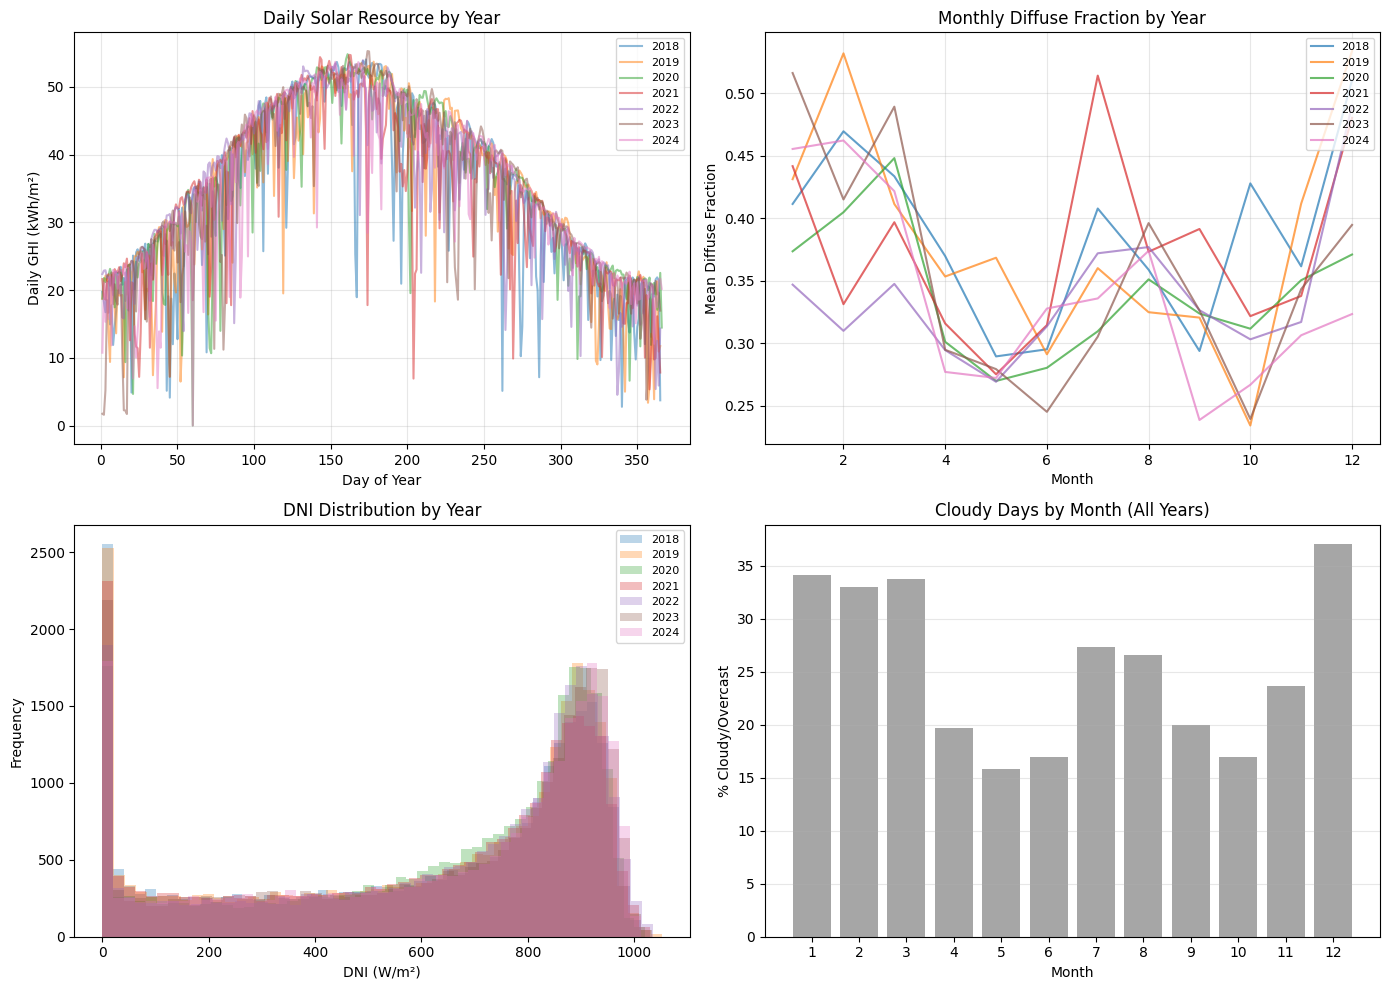

In [20]:
# Visualize multi-year patterns
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Daily GHI by year
ax1 = axes[0, 0]
for year in nsrdb_data.index.year.unique():
    year_data = nsrdb_data[nsrdb_data.index.year == year]
    daily_ghi = year_data['ghi'].resample('D').sum() / 1000
    ax1.plot(daily_ghi.index.dayofyear, daily_ghi.values, alpha=0.5, label=str(year))
ax1.set_xlabel('Day of Year')
ax1.set_ylabel('Daily GHI (kWh/m²)')
ax1.set_title('Daily Solar Resource by Year')
ax1.legend(loc='upper right', fontsize=8)
ax1.grid(True, alpha=0.3)

# Monthly diffuse fraction
ax2 = axes[0, 1]
monthly_diffuse = daytime.groupby([daytime.index.year, daytime.index.month])['diffuse_fraction'].mean().unstack(0)
monthly_diffuse.plot(ax=ax2, alpha=0.7)
ax2.set_xlabel('Month')
ax2.set_ylabel('Mean Diffuse Fraction')
ax2.set_title('Monthly Diffuse Fraction by Year')
ax2.legend(loc='upper right', fontsize=8)
ax2.grid(True, alpha=0.3)

# DNI distribution
ax3 = axes[1, 0]
for year in nsrdb_data.index.year.unique():
    year_daytime = daytime[daytime.index.year == year]
    ax3.hist(year_daytime['dni'], bins=50, alpha=0.3, label=str(year))
ax3.set_xlabel('DNI (W/m²)')
ax3.set_ylabel('Frequency')
ax3.set_title('DNI Distribution by Year')
ax3.legend(fontsize=8)

# Cloudy days by month (all years combined)
ax4 = axes[1, 1]
cloudy_frac = daytime[daytime['weather_type'].isin(['cloudy', 'overcast'])].groupby(
    daytime[daytime['weather_type'].isin(['cloudy', 'overcast'])].index.month
).size() / daytime.groupby(daytime.index.month).size() * 100
ax4.bar(cloudy_frac.index, cloudy_frac.values, color='gray', alpha=0.7)
ax4.set_xlabel('Month')
ax4.set_ylabel('% Cloudy/Overcast')
ax4.set_title('Cloudy Days by Month (All Years)')
ax4.set_xticks(range(1, 13))
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [21]:
# Monsoon analysis (July-September)
print("📊 Monsoon Season Analysis (Jul-Sep):")
print("="*50)

for year in sorted(nsrdb_data.index.year.unique()):
    year_data = daytime[daytime.index.year == year]
    monsoon = year_data[(year_data.index.month >= 7) & (year_data.index.month <= 9)]
    
    if len(monsoon) > 0:
        cloudy_pct = (monsoon['weather_type'].isin(['cloudy', 'overcast'])).mean() * 100
        mean_diffuse = monsoon['diffuse_fraction'].mean()
        print(f"{year}: {cloudy_pct:.1f}% cloudy/overcast, diffuse_frac={mean_diffuse:.2f}")

📊 Monsoon Season Analysis (Jul-Sep):
2018: 24.1% cloudy/overcast, diffuse_frac=0.36
2019: 23.1% cloudy/overcast, diffuse_frac=0.34
2020: 19.7% cloudy/overcast, diffuse_frac=0.33
2021: 34.1% cloudy/overcast, diffuse_frac=0.43
2022: 26.1% cloudy/overcast, diffuse_frac=0.36
2023: 25.5% cloudy/overcast, diffuse_frac=0.34
2024: 21.4% cloudy/overcast, diffuse_frac=0.32


## 3. Train/Validation/Test Split

In [22]:
# Split by year
train_years = [2018, 2019, 2020, 2021, 2022]
val_years = [2023]
test_years = [2024]

# Handle case where not all years are present
available_years = sorted(nsrdb_data.index.year.unique())
print(f"Available years: {available_years}")

train_years = [y for y in train_years if y in available_years]
val_years = [y for y in val_years if y in available_years]
test_years = [y for y in test_years if y in available_years]

# If 2024 not available, use last year as test
if len(test_years) == 0:
    test_years = [available_years[-1]]
    val_years = [available_years[-2]] if len(available_years) > 1 else []
    train_years = [y for y in available_years if y not in test_years + val_years]

print(f"\nTrain years: {train_years}")
print(f"Validation years: {val_years}")
print(f"Test years: {test_years}")

# Get dates for each split
all_dates = nsrdb_data.index.normalize().unique()

train_dates = [str(d.date()) for d in all_dates if d.year in train_years]
val_dates = [str(d.date()) for d in all_dates if d.year in val_years]
test_dates = [str(d.date()) for d in all_dates if d.year in test_years]

print(f"\nTrain: {len(train_dates)} days")
print(f"Validation: {len(val_dates)} days")
print(f"Test: {len(test_dates)} days")

Available years: [2018, 2019, 2020, 2021, 2022, 2023, 2024]

Train years: [2018, 2019, 2020, 2021, 2022]
Validation years: [2023]
Test years: [2024]

Train: 1825 days
Validation: 365 days
Test: 365 days


## 4. Environment Setup

In [23]:
class PowerModel:
    def __init__(self, site: SiteConfig):
        self.site = site
    
    def calculate_power(self, poa_global: float, temp_air: float, shading_fraction: float = 0.0) -> float:
        if poa_global <= 0:
            return 0.0
        temp_cell = temp_air + 0.03 * poa_global
        temp_factor = max(0.5, min(1.1, 1 + self.site.temp_coefficient * (temp_cell - 25)))
        effective_poa = poa_global * (1 - shading_fraction)
        power_kw = effective_poa / 1000 * self.site.array_area * self.site.module_efficiency * temp_factor * (1 - self.site.system_losses)
        return min(max(0.0, power_kw), self.site.capacity_kw)

In [24]:
class MultiYearTrackerEnv(gym.Env):
    """
    Tracker environment for multi-year NSRDB data.
    Supports 10-minute resolution.
    """
    
    metadata = {'render_modes': ['human']}
    
    def __init__(
        self,
        weather_data: pd.DataFrame,
        site: Optional[SiteConfig] = None,
        random_seed: Optional[int] = None,
        movement_penalty: float = 0.001,
        available_dates: Optional[List[str]] = None,
    ):
        super().__init__()
        
        self.site = site or SiteConfig()
        self.full_weather_data = weather_data
        self.movement_penalty = movement_penalty
        self.rng = np.random.default_rng(random_seed)
        
        # Detect data interval
        time_diff = weather_data.index.to_series().diff().median()
        self.interval_minutes = time_diff.total_seconds() / 60
        self.timestep_hours = self.interval_minutes / 60
        
        # Available dates
        if available_dates is not None:
            self.available_dates = [pd.Timestamp(d, tz=self.site.timezone) for d in available_dates]
        else:
            self.available_dates = list(self.full_weather_data.index.normalize().unique())
        
        self.power_model = PowerModel(self.site)
        
        # State: 10 features
        self.state_dim = 10
        self.observation_space = spaces.Box(low=-1.0, high=1.0, shape=(self.state_dim,), dtype=np.float32)
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)
        
        # Episode state
        self.day_data = None
        self.solar_pos = None
        self.current_step = 0
        self.current_angle = 0.0
        self.episode_energy = 0.0
        self.history = []
    
    def _get_solar_position(self, times: pd.DatetimeIndex) -> pd.DataFrame:
        return solarposition.get_solarposition(
            times, self.site.latitude, self.site.longitude, self.site.altitude
        )
    
    def _calculate_poa(self, tracker_angle: float, solar_zenith: float, solar_azimuth: float,
                       dni: float, ghi: float, dhi: float) -> float:
        if solar_zenith >= 90 or ghi <= 0:
            return 0.0
        
        surface_tilt = abs(tracker_angle)
        if tracker_angle > 0:
            surface_azimuth = (self.site.axis_azimuth + 90) % 360
        elif tracker_angle < 0:
            surface_azimuth = (self.site.axis_azimuth - 90) % 360
        else:
            surface_azimuth = self.site.axis_azimuth
        
        try:
            dni_extra = irradiance.get_extra_radiation(self.current_time)
            airmass = atmosphere.get_relative_airmass(solar_zenith)
            poa = irradiance.get_total_irradiance(
                surface_tilt=surface_tilt, surface_azimuth=surface_azimuth,
                solar_zenith=solar_zenith, solar_azimuth=solar_azimuth,
                dni=dni, ghi=ghi, dhi=dhi, dni_extra=dni_extra, airmass=airmass, model='perez'
            )
            return max(0.0, float(poa['poa_global']))
        except:
            return max(0.0, ghi)
    
    def _calculate_shading(self, tracker_angle: float) -> float:
        solar = self.solar_pos.loc[self.current_time]
        if solar['apparent_zenith'] >= 90:
            return 1.0
        try:
            shaded = shading.shaded_fraction1d(
                solar_zenith=solar['apparent_zenith'], solar_azimuth=solar['azimuth'],
                axis_azimuth=self.site.axis_azimuth, shaded_row_rotation=tracker_angle,
                collector_width=self.site.collector_width, pitch=self.site.row_pitch,
                axis_tilt=0, cross_axis_slope=self.site.terrain_slope
            )
            return float(shaded)
        except:
            return 0.0
    
    def _get_backtracking_angle(self) -> float:
        solar = self.solar_pos.loc[self.current_time]
        if solar['apparent_elevation'] <= 0:
            return 0.0
        tracking_data = tracking.singleaxis(
            apparent_zenith=solar['apparent_zenith'],
            apparent_azimuth=solar['azimuth'],
            axis_tilt=0, axis_azimuth=self.site.axis_azimuth,
            max_angle=self.site.max_angle, backtrack=True, gcr=self.site.gcr
        )
        angle = tracking_data['tracker_theta']
        return float(angle) if not pd.isna(angle) else 0.0
    
    def _get_state(self) -> np.ndarray:
        weather = self.day_data.loc[self.current_time]
        solar = self.solar_pos.loc[self.current_time]
        
        elevation = solar['apparent_elevation'] / 90.0
        azimuth_rad = np.radians(solar['azimuth'])
        
        ghi_norm = weather['ghi'] / 1200.0
        dni_norm = weather['dni'] / 1000.0
        diffuse_frac = weather.get('diffuse_fraction', weather['dhi'] / max(weather['ghi'], 1))
        diffuse_frac = min(1.0, max(0.0, diffuse_frac))
        
        angle_norm = self.current_angle / self.site.max_angle
        
        hour = self.current_time.hour + self.current_time.minute / 60
        hour_sin = np.sin(2 * np.pi * hour / 24)
        hour_cos = np.cos(2 * np.pi * hour / 24)
        
        temp_norm = (weather['temp_air'] - 25) / 25 if 'temp_air' in weather else 0.0
        
        state = np.array([
            elevation, np.sin(azimuth_rad), np.cos(azimuth_rad),
            ghi_norm, dni_norm, diffuse_frac,
            angle_norm, hour_sin, hour_cos, temp_norm
        ], dtype=np.float32)
        
        return np.clip(state, -1.0, 1.0)
    
    def _get_info(self) -> Dict[str, Any]:
        weather = self.day_data.loc[self.current_time]
        solar = self.solar_pos.loc[self.current_time]
        return {
            'time': self.current_time,
            'solar_elevation': solar['apparent_elevation'],
            'solar_azimuth': solar['azimuth'],
            'ghi': weather['ghi'],
            'dni': weather['dni'],
            'dhi': weather['dhi'],
            'tracker_angle': self.current_angle,
            'backtrack_angle': self._get_backtracking_angle(),
            'episode_energy': self.episode_energy,
        }
    
    def reset(self, seed: Optional[int] = None, options: Optional[Dict] = None) -> Tuple[np.ndarray, Dict]:
        super().reset(seed=seed)
        
        if seed is not None:
            self.rng = np.random.default_rng(seed)
        
        # Select a date
        if options and 'date' in options:
            date = pd.Timestamp(options['date'], tz=self.site.timezone)
        else:
            date = self.rng.choice(self.available_dates)
        
        # Get weather data for this day
        day_start = date.normalize()
        day_end = day_start + timedelta(days=1)
        self.day_data = self.full_weather_data[day_start:day_end].copy()
        
        if len(self.day_data) == 0:
            date = self.rng.choice(self.available_dates)
            day_start = date.normalize()
            day_end = day_start + timedelta(days=1)
            self.day_data = self.full_weather_data[day_start:day_end].copy()
        
        self.solar_pos = self._get_solar_position(self.day_data.index)
        
        daylight_mask = self.solar_pos['apparent_elevation'] > 0
        self.daylight_times = self.day_data.index[daylight_mask]
        
        if len(self.daylight_times) == 0:
            self.daylight_times = self.day_data.index[:10]
        
        self.current_step = 0
        self.current_time = self.daylight_times[0]
        self.current_angle = 0.0
        self.episode_energy = 0.0
        self.history = []
        
        return self._get_state(), self._get_info()
    
    def step(self, action: np.ndarray) -> Tuple[np.ndarray, float, bool, bool, Dict]:
        action_value = float(action[0]) if isinstance(action, np.ndarray) else float(action)
        new_angle = action_value * self.site.max_angle
        new_angle = np.clip(new_angle, -self.site.max_angle, self.site.max_angle)
        
        angle_change = abs(new_angle - self.current_angle)
        self.current_angle = new_angle
        
        weather = self.day_data.loc[self.current_time]
        solar = self.solar_pos.loc[self.current_time]
        
        poa = self._calculate_poa(
            self.current_angle, solar['apparent_zenith'], solar['azimuth'],
            weather['dni'], weather['ghi'], weather['dhi']
        )
        shading_frac = self._calculate_shading(self.current_angle)
        
        power_kw = self.power_model.calculate_power(poa, weather.get('temp_air', 25), shading_frac)
        energy_kwh = power_kw * self.timestep_hours
        
        max_energy = self.site.capacity_kw * self.timestep_hours
        reward = energy_kwh / max_energy - self.movement_penalty * angle_change
        
        self.episode_energy += energy_kwh
        
        self.history.append({
            'time': self.current_time,
            'angle': self.current_angle,
            'backtrack_angle': self._get_backtracking_angle(),
            'poa': poa,
            'shading': shading_frac,
            'power_kw': power_kw,
            'energy_kwh': energy_kwh,
            'ghi': weather['ghi'],
            'dni': weather['dni'],
        })
        
        self.current_step += 1
        terminated = self.current_step >= len(self.daylight_times)
        
        if not terminated:
            self.current_time = self.daylight_times[self.current_step]
        
        info = self._get_info()
        info['power_kw'] = power_kw
        info['energy_kwh'] = energy_kwh
        info['shading'] = shading_frac
        info['angle_change'] = angle_change
        
        return self._get_state(), reward, terminated, False, info
    
    def get_history_df(self) -> pd.DataFrame:
        return pd.DataFrame(self.history)


print("MultiYearTrackerEnv defined!")

MultiYearTrackerEnv defined!


In [25]:
# Create environments
train_env = MultiYearTrackerEnv(
    weather_data=nsrdb_data,
    site=SITE,
    random_seed=42,
    movement_penalty=0.001,
    available_dates=train_dates
)

val_env = MultiYearTrackerEnv(
    weather_data=nsrdb_data,
    site=SITE,
    random_seed=123,
    movement_penalty=0.001,
    available_dates=val_dates
)

test_env = MultiYearTrackerEnv(
    weather_data=nsrdb_data,
    site=SITE,
    random_seed=999,
    movement_penalty=0.001,
    available_dates=test_dates
)

# Verify
check_env(train_env, warn=True)
print(f"✅ Environment check passed!")
print(f"Data interval: {train_env.interval_minutes:.0f} minutes")
print(f"Train dates: {len(train_dates)}")
print(f"Val dates: {len(val_dates)}")
print(f"Test dates: {len(test_dates)}")

✅ Environment check passed!
Data interval: 10 minutes
Train dates: 1825
Val dates: 365
Test dates: 365


## 5. Training

In [26]:
class MultiYearCallback(BaseCallback):
    """Callback with validation on held-out year."""
    
    def __init__(self, val_env, eval_freq: int = 20000, verbose: int = 1):
        super().__init__(verbose)
        self.val_env = val_env
        self.eval_freq = eval_freq
        self.best_vs_baseline = -np.inf
        self.results = []
    
    def _evaluate(self, get_action_fn, n_episodes=5):
        energies = []
        for _ in range(n_episodes):
            state, info = self.val_env.reset()
            done, ep_energy = False, 0
            while not done:
                action = get_action_fn(state, info)
                state, _, terminated, truncated, info = self.val_env.step(action)
                ep_energy += info.get('energy_kwh', 0)
                done = terminated or truncated
            energies.append(ep_energy)
        return np.mean(energies)
    
    def _on_step(self) -> bool:
        if self.n_calls % self.eval_freq == 0:
            # RL
            def rl_fn(state, info):
                action, _ = self.model.predict(state, deterministic=True)
                return action
            rl_energy = self._evaluate(rl_fn)
            
            # Backtracking
            def bt_fn(state, info):
                return np.array([info['backtrack_angle'] / 60.0])
            bt_energy = self._evaluate(bt_fn)
            
            diff_pct = (rl_energy / bt_energy - 1) * 100 if bt_energy > 0 else 0
            
            self.results.append({
                'step': self.n_calls,
                'rl_energy': rl_energy,
                'bt_energy': bt_energy,
                'diff_pct': diff_pct,
            })
            
            status = "🎯" if diff_pct > 0 else "📉" if diff_pct < -1 else "➖"
            print(f"Step {self.n_calls:,}: RL={rl_energy:.0f}, BT={bt_energy:.0f}, Diff={diff_pct:+.2f}% {status}")
            
            if diff_pct > self.best_vs_baseline:
                self.best_vs_baseline = diff_pct
                if diff_pct > 0:
                    print(f"   🏆 New best! +{diff_pct:.2f}%")
        
        return True


print("Callback defined!")

Callback defined!


In [27]:
# Training config - more steps for more data
TRAINING_CONFIG = {
    'total_timesteps': 500_000,  # 500K steps with 5 years of training data
    'eval_freq': 25_000,
}

SAC_CONFIG = {
    'learning_rate': 3e-4,
    'buffer_size': 200_000,  # Larger buffer for more data
    'batch_size': 256,
    'tau': 0.005,
    'gamma': 0.99,
    'policy_kwargs': dict(net_arch=[256, 256]),
}

print(f"Training for {TRAINING_CONFIG['total_timesteps']:,} timesteps")
print(f"Estimated time: ~1.5-2 hours on M3 Pro")

Training for 500,000 timesteps
Estimated time: ~1.5-2 hours on M3 Pro


In [28]:
# Create agent
sac_multiyear = SAC(
    policy='MlpPolicy',
    env=train_env,
    learning_rate=SAC_CONFIG['learning_rate'],
    buffer_size=SAC_CONFIG['buffer_size'],
    batch_size=SAC_CONFIG['batch_size'],
    tau=SAC_CONFIG['tau'],
    gamma=SAC_CONFIG['gamma'],
    policy_kwargs=SAC_CONFIG['policy_kwargs'],
    verbose=0,
    seed=42,
    device=DEVICE,
)

print(f"SAC agent created!")

SAC agent created!


In [29]:
# Train!
print(f"\n{'='*70}")
print(f"  Multi-Year Training: {train_years}")
print(f"  Validation: {val_years}")
print(f"  Test (held-out): {test_years}")
print(f"  Total timesteps: {TRAINING_CONFIG['total_timesteps']:,}")
print(f"{'='*70}\n")

callback = MultiYearCallback(
    val_env=val_env,
    eval_freq=TRAINING_CONFIG['eval_freq'],
    verbose=1
)

start_time = time.time()

sac_multiyear.learn(
    total_timesteps=TRAINING_CONFIG['total_timesteps'],
    callback=callback,
    progress_bar=True
)

training_time = time.time() - start_time
print(f"\n✅ Training complete in {training_time/60:.1f} minutes")
print(f"Best vs backtracking (validation): {callback.best_vs_baseline:+.2f}%")

Output()


  Multi-Year Training: [2018, 2019, 2020, 2021, 2022]
  Validation: [2023]
  Test (held-out): [2024]
  Total timesteps: 500,000



Step 25,000: RL=1753, BT=2479, Diff=-29.29% 📉

🏆 New best! +55.23%

Step 75,000: RL=2559, BT=2345, Diff=+9.13% 🎯

Step 175,000: RL=2231, BT=1706, Diff=+30.78% 🎯

Step 200,000: RL=3066, BT=2148, Diff=+42.73% 🎯

Step 250,000: RL=2744, BT=3128, Diff=-12.29% 📉

Step 275,000: RL=2383, BT=2867, Diff=-16.90% 📉

Step 300,000: RL=2571, BT=2072, Diff=+24.07% 🎯

Step 325,000: RL=3392, BT=2758, Diff=+23.00% 🎯

Step 350,000: RL=3353, BT=3146, Diff=+6.57% 🎯

Step 375,000: RL=3203, BT=2674, Diff=+19.82% 🎯

Step 400,000: RL=2417, BT=2427, Diff=-0.44% ➖

Step 450,000: RL=1546, BT=2741, Diff=-43.59% 📉

Step 475,000: RL=2306, BT=2559, Diff=-9.89% 📉


✅ Training complete in 99.7 minutes
Best vs backtracking (validation): +64.99%


## 6. Final Evaluation on Held-Out Test Year

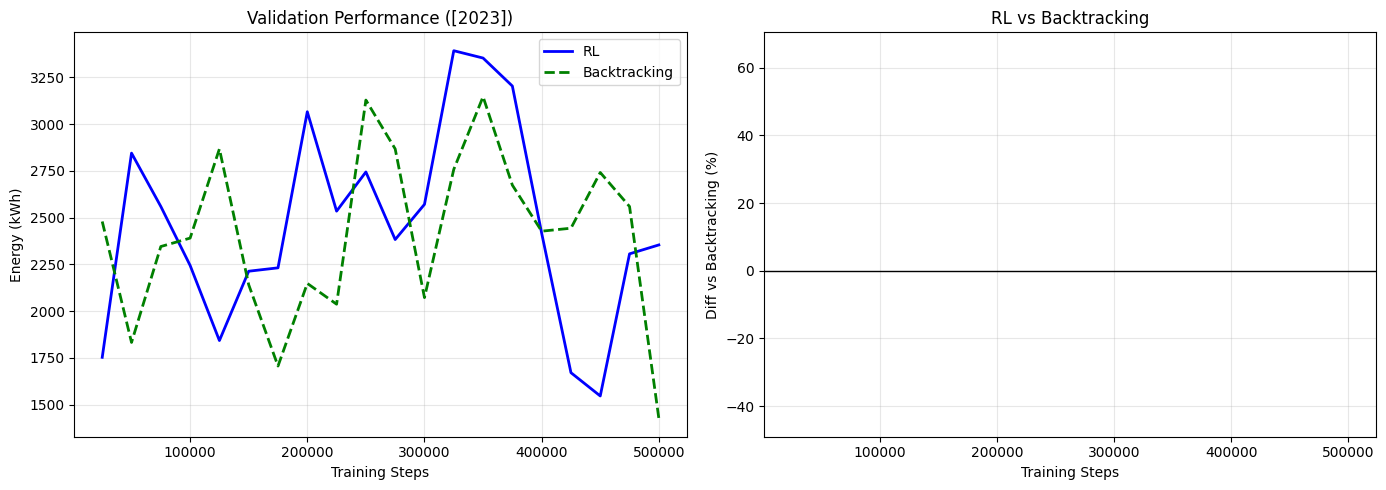

In [30]:
# Plot training progress
results_df = pd.DataFrame(callback.results)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
ax1.plot(results_df['step'], results_df['rl_energy'], 'b-', label='RL', linewidth=2)
ax1.plot(results_df['step'], results_df['bt_energy'], 'g--', label='Backtracking', linewidth=2)
ax1.set_xlabel('Training Steps')
ax1.set_ylabel('Energy (kWh)')
ax1.set_title(f'Validation Performance ({val_years})')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = axes[1]
colors = ['green' if x > 0 else 'red' for x in results_df['diff_pct']]
ax2.bar(results_df['step'], results_df['diff_pct'], color=colors, alpha=0.7)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax2.set_xlabel('Training Steps')
ax2.set_ylabel('Diff vs Backtracking (%)')
ax2.set_title('RL vs Backtracking')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [31]:
def evaluate_on_dates(agent, env_class, weather_data, site, dates, name=""):
    """Evaluate agent on a list of dates."""
    rl_energies = []
    bt_energies = []
    
    print(f"Evaluating on {len(dates)} days ({name})...")
    
    for i, date in enumerate(dates):
        if i % 50 == 0:
            print(f"  Progress: {i}/{len(dates)}")
        
        try:
            # RL
            env = env_class(weather_data=weather_data, site=site, random_seed=42, available_dates=[date])
            state, info = env.reset(options={'date': date})
            done, rl_e = False, 0
            while not done:
                action, _ = agent.predict(state, deterministic=True)
                state, _, term, trunc, info = env.step(action)
                rl_e += info['energy_kwh']
                done = term or trunc
            
            # Backtracking
            env = env_class(weather_data=weather_data, site=site, random_seed=42, available_dates=[date])
            state, info = env.reset(options={'date': date})
            done, bt_e = False, 0
            while not done:
                action = np.array([info['backtrack_angle'] / 60.0])
                state, _, term, trunc, info = env.step(action)
                bt_e += info['energy_kwh']
                done = term or trunc
            
            rl_energies.append(rl_e)
            bt_energies.append(bt_e)
        except Exception as e:
            continue
    
    return rl_energies, bt_energies


# Evaluate on TEST year (completely held out)
print(f"\n📊 FINAL TEST: Evaluating on {test_years} (completely held-out)")
print("="*60)

rl_test, bt_test = evaluate_on_dates(
    sac_multiyear, 
    MultiYearTrackerEnv,
    nsrdb_data,
    SITE,
    test_dates,
    name=f"Test {test_years}"
)

print(f"\n📊 Test Year Results ({test_years}):")
print(f"   Days evaluated: {len(rl_test)}")
print(f"   Total RL: {sum(rl_test):,.0f} kWh")
print(f"   Total BT: {sum(bt_test):,.0f} kWh")
print(f"   Overall: {(sum(rl_test)/sum(bt_test)-1)*100:+.2f}%")

daily_diffs = [(r/b-1)*100 for r,b in zip(rl_test, bt_test) if b > 0]
print(f"\n   Daily stats:")
print(f"   Mean diff: {np.mean(daily_diffs):+.2f}%")
print(f"   Median diff: {np.median(daily_diffs):+.2f}%")
print(f"   Best day: {max(daily_diffs):+.2f}%")
print(f"   Worst day: {min(daily_diffs):+.2f}%")
print(f"   Days beating BT: {sum(1 for d in daily_diffs if d > 0.5)}/{len(daily_diffs)}")


📊 FINAL TEST: Evaluating on [2024] (completely held-out)
Evaluating on 365 days (Test [2024])...
  Progress: 0/365
  Progress: 50/365
  Progress: 100/365
  Progress: 150/365
  Progress: 200/365
  Progress: 250/365
  Progress: 300/365
  Progress: 350/365

📊 Test Year Results ([2024]):
   Days evaluated: 365
   Total RL: 841,042 kWh
   Total BT: 858,579 kWh
   Overall: -2.04%

   Daily stats:
   Mean diff: -2.43%
   Median diff: -2.26%
   Best day: +2.93%
   Worst day: -8.18%
   Days beating BT: 11/365


In [32]:
# Compare validation vs test performance
print(f"\n📊 Validation vs Test Comparison:")
print("="*60)

# Validation
rl_val, bt_val = evaluate_on_dates(
    sac_multiyear,
    MultiYearTrackerEnv,
    nsrdb_data,
    SITE,
    val_dates[:100],  # Sample for speed
    name=f"Val {val_years}"
)

val_diff = (sum(rl_val)/sum(bt_val)-1)*100
test_diff = (sum(rl_test)/sum(bt_test)-1)*100

print(f"\nValidation ({val_years}): {val_diff:+.2f}%")
print(f"Test ({test_years}): {test_diff:+.2f}%")


📊 Validation vs Test Comparison:
Evaluating on 100 days (Val [2023])...
  Progress: 0/100
  Progress: 50/100

Validation ([2023]): -3.31%
Test ([2024]): -2.04%


In [33]:
# Analyze by weather type in test year
print(f"\n📊 Test Year Performance by Weather Type:")
print("="*60)

# Classify test days
test_weather_results = []

for date, rl_e, bt_e in zip(test_dates[:len(rl_test)], rl_test, bt_test):
    try:
        day_data = nsrdb_data[date]
        daytime = day_data[day_data['ghi'] > 0]
        if len(daytime) == 0:
            continue
        avg_diffuse = (daytime['dhi'] / daytime['ghi'].replace(0, 1)).mean()
        
        if avg_diffuse < 0.2:
            weather = 'clear'
        elif avg_diffuse < 0.4:
            weather = 'partly_cloudy'
        else:
            weather = 'cloudy'
        
        test_weather_results.append({
            'date': date,
            'weather': weather,
            'rl': rl_e,
            'bt': bt_e,
            'diff': (rl_e/bt_e-1)*100 if bt_e > 0 else 0
        })
    except:
        continue

test_df = pd.DataFrame(test_weather_results)

for weather in ['clear', 'partly_cloudy', 'cloudy']:
    subset = test_df[test_df['weather'] == weather]
    if len(subset) > 0:
        total_rl = subset['rl'].sum()
        total_bt = subset['bt'].sum()
        diff = (total_rl/total_bt-1)*100
        wins = (subset['diff'] > 0.5).sum()
        print(f"{weather:15s}: {len(subset):3d} days, {diff:+.2f}%, wins={wins}/{len(subset)}")


📊 Test Year Performance by Weather Type:


KeyError: 'weather'

## 7. Summary

In [34]:
print("\n" + "="*70)
print("  MULTI-YEAR TRAINING SUMMARY")
print("="*70)

print(f"\n📊 Data:")
print(f"   Years: {min(available_years)}-{max(available_years)}")
print(f"   Total records: {len(nsrdb_data):,}")
print(f"   Interval: {train_env.interval_minutes:.0f} minutes")

print(f"\n📊 Training:")
print(f"   Train years: {train_years}")
print(f"   Validation years: {val_years}")
print(f"   Test years: {test_years}")
print(f"   Timesteps: {TRAINING_CONFIG['total_timesteps']:,}")
print(f"   Training time: {training_time/60:.1f} minutes")

print(f"\n📊 Results:")
print(f"   Best validation: {callback.best_vs_baseline:+.2f}%")
if len(rl_test) > 0:
    print(f"   Test overall: {(sum(rl_test)/sum(bt_test)-1)*100:+.2f}%")
    print(f"   Test days beating BT: {sum(1 for d in daily_diffs if d > 0.5)}/{len(daily_diffs)}")

print(f"\n🔑 Conclusion:")
if len(rl_test) > 0:
    test_result = (sum(rl_test)/sum(bt_test)-1)*100
    if test_result > 0.5:
        print(f"   ✅ RL beats backtracking by {test_result:.2f}% on held-out test year!")
    elif test_result > -0.5:
        print(f"   ➖ RL matches backtracking (within 0.5%) on held-out test year")
    else:
        print(f"   ❌ RL underperforms backtracking by {-test_result:.2f}% on held-out test year")


  MULTI-YEAR TRAINING SUMMARY

📊 Data:
   Years: 2018-2024
   Total records: 367,920
   Interval: 10 minutes

📊 Training:
   Train years: [2018, 2019, 2020, 2021, 2022]
   Validation years: [2023]
   Test years: [2024]
   Timesteps: 500,000
   Training time: 99.7 minutes

📊 Results:
   Best validation: +64.99%
   Test overall: -2.04%
   Test days beating BT: 11/365

🔑 Conclusion:
   ❌ RL underperforms backtracking by 2.04% on held-out test year


In [ ]:
# Save model
import os
os.makedirs('models', exist_ok=True)
sac_multiyear.save('models/sac_multiyear_2018_2024')
print("✅ Model saved!")